# Getting data from a data frame

## Overview

### Objectives
- Is there a relationship between puzzle difficulty and popularity?

### Topics to be covered
- Subsetting rows of a data frame
- Selecting columns of a data frame
- Creating local linear regression (LOESS) models
- Visualizing LOESS predictions

## Previously

- A DataFrame was created from a compressed CSV file of lichess database
- we want to know the relationship between puzzle difficulty and popularity

In [1]:
using DataFrames, Downloads, CodecZstd, CSV
file = "new_puzzles.csv.zst"
url = "https://database.lichess.org/lichess_db_puzzle.csv.zst"
if isfile(file)
    @info "File already downloaded"
else
    @info "Downloading file"
    Downloads.download(url, file)
end
compressed = read(file)
plain = transcode(ZstdDecompressor, compressed)
puzzles = CSV.read(plain, delim=",", maxwarnings=0, DataFrame, header=["PuzzleId", "FEN", "Moves", "Rating", "RatingDeviation", "Popularity", "NbPlays", "Themes", "GameUrl", "OpeningTags"]);

┌ Info: File already downloaded
└ @ Main /mnt/w/1t-nvme/projects/Talk-Julia/julia/07-DataFrames-2.ipynb:5


In [2]:
compressed = nothing
plain = nothing

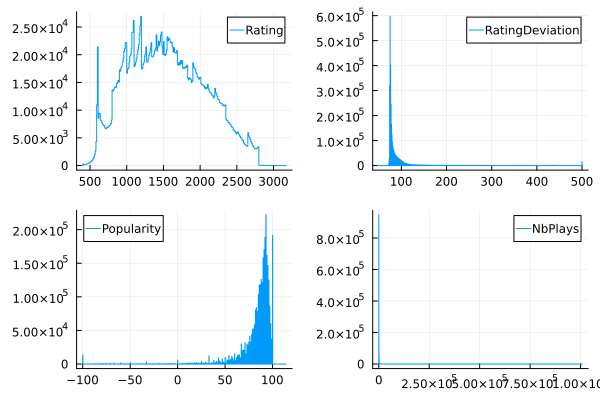

In [3]:
using Plots
plot([histogram(puzzles[!, col]; label=col) for col in ["Rating", "RatingDeviation", "Popularity", "NbPlays"]]..., layout=(2, 2))

Notes:
- Rating: Difficulty of the puzzle
- RatingDeviation: Accuracy of assessment of difficulty of the puzzle
- Popularity: How much the puzzle is liked by users (the higher, the better)
- NbPlays: Number of times a given puzzle was played

## Data cleaning

- Keep puzzles that were played enough times
  - `NbPlays` >= median(`NbPlays`)
- Remove very easy and hard puzzles
  - `Rating` between median and 99 percentile

In [4]:
using Statistics
# puzzles played enough times
f1 = puzzles.NbPlays .> median(puzzles.NbPlays)
# rating not extreme
f2 = median(puzzles.Rating) .< puzzles.Rating .< quantile(puzzles.Rating, 0.99)
qc = f1 .&& f2
sum(qc)

756341

In [5]:
dat = puzzles[qc, [:Rating, :Popularity]]
first(dat, 5)

Row,Rating,Popularity
,Int64,Int64
1,1789,95
2,1533,92
3,1554,89
4,1800,91
5,2578,90


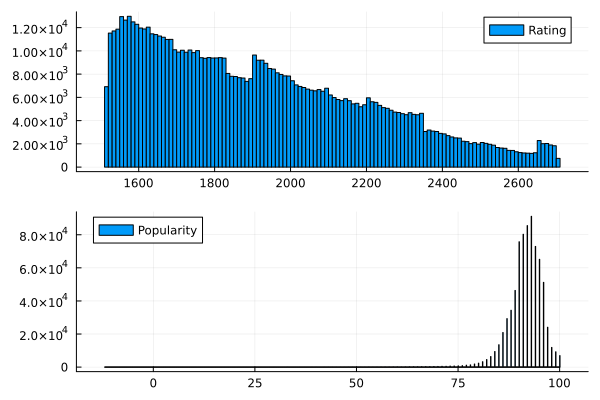

In [6]:
plot([histogram(dat[!, col]; label=col) for col in ["Rating", "Popularity"]]..., layout=(2, 1))

### Column selectors

In [7]:
puzzles[1, "Rating"] # a single cell

1789

In [8]:
puzzles[:, "Rating"] # select column "Ratings" from puzzles

3191820-element Vector{Int64}:
 1789
 1482
 1172
 1565
 1533
 1430
 1554
 1961
 1039
 2051
    ⋮
 1937
  830
 2041
  958
 1058
 1011
 1695
 2492
 2285

In [9]:
row1 = puzzles[1, ["Rating", "Popularity"]] # DataFrameRow

Row,Rating,Popularity
,Int64,Int64
1,1789,95


In [10]:
row1["Rating"]

1789

In [11]:
row1[:Rating]

1789

In [12]:
row1.Rating, row1."Rating"

(1789, 1789)

```julia
qc = puzzles[row_selector, [column_selector]]
```

### A summary of column selectors

- A vector of `String`, `Symbol`, or `Integer`
- A vector of `Boolean`, whose length is the number of columns of the DataFrame
- A regular expression
- A `Not` expression, e.g., `df[:, Not([4, 6])]` selects all columns except the 4th and 6th
- A `Between` expression. `Between("Rating", "Popularity")` selects all columns between `Rating` and `Popularity` (inclusive)
- A colon `:`, or `All()` selects all columns
- A `Cols` selector
    - `Cols(r"Rating", "NbPlays")` selects columns whose names match the regular expression `r"Rating"` and `"NbPlays"`
    - `Cols(startswith("P"))` selects columns whose names start with `P`
- use function `names`

### A summary of row selectors

- A vector of `Integer`s
- A vector of `Boolean`s, whose length is the number of rows of the DataFrame
- A `Not` expression
- A colon `:`
- An exclamation mark `!`, picks without copying

### Views

```julia
@view df[row_selector, column_selector]
```

- Create a view is faster than a copy
- Be careful when modifying a view

## Relationship between puzzle difficulty and popularity

### Mean popularity by difficulty

We use aggregation from Base Julia.

In [13]:
describe(dat)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Int64,Float64,Int64,Int64,DataType
1,Rating,1921.41,1514,1873.0,2703,0,Int64
2,Popularity,91.4631,-12,92.0,100,0,Int64


In [14]:
rate_mapping = Dict{Int, Vector{Int}}()
for (i, rating) in enumerate(dat.Rating)
    if haskey(rate_mapping, rating)
        push!(rate_mapping[rating], i)
    else
        rate_mapping[rating] = [i]
    end
end
first(rate_mapping, 5)

5-element Vector{Pair{Int64, Vector{Int64}}}:
 2108 => [159, 822, 998, 6123, 6519, 10393, 11620, 12004, 12117, 12456  …  739541, 740019, 741020, 741890, 741983, 744079, 745770, 746552, 749637, 753200]
 2261 => [1852, 1880, 2841, 4002, 8681, 16352, 17307, 20974, 21119, 23141  …  739931, 740021, 741828, 745016, 746009, 746608, 746750, 750516, 750917, 756310]
 1953 => [549, 935, 1932, 3334, 4157, 5695, 5884, 6675, 8051, 14555  …  749506, 749618, 749845, 751046, 752451, 753030, 754151, 755097, 755970, 756018]
 2288 => [269, 568, 698, 5196, 5324, 5891, 7225, 7729, 7836, 9722  …  741595, 742062, 742856, 743532, 748137, 749921, 750001, 753693, 756209, 756254]
 1546 => [1211, 2992, 4270, 5706, 5908, 6067, 6275, 7037, 7669, 8978  …  751708, 751949, 752200, 753179, 753286, 753670, 753718, 754015, 754190, 754357]

In [15]:
# Has all rows stored in rate_mapping?
nrow = 0
for (rating, indices) in rate_mapping
    nrow += length(indices)
end
nrow, size(dat, 1)

(756341, 756341)

In [16]:
rows = Int[]
for (rating, indices) in rate_mapping
    append!(rows, indices)
end
length(unique(rows))

756341

In [17]:
# What is the popularity of a 2023 rating?
mean(dat[rate_mapping[2023], :Popularity])

91.30191256830601

In [18]:
ratings = sort(unique(dat.Rating))

1190-element Vector{Int64}:
 1514
 1515
 1516
 1517
 1518
 1519
 1520
 1521
 1522
 1523
    ⋮
 2695
 2696
 2697
 2698
 2699
 2700
 2701
 2702
 2703

In [19]:
mean_popularities = map(ratings) do rating
    mean(dat[rate_mapping[rating], :Popularity])
end

1190-element Vector{Float64}:
 91.50089285714286
 91.29734361610969
 91.46286231884058
 91.46898895497026
 91.46113989637306
 91.82677824267782
 91.28403361344537
 91.42907488986783
 91.31239242685025
 91.21483375959079
  ⋮
 89.67980295566502
 89.86338797814207
 90.10055865921788
 90.21052631578948
 90.10526315789474
 89.81521739130434
 89.74757281553399
 89.68108108108108
 89.99425287356321

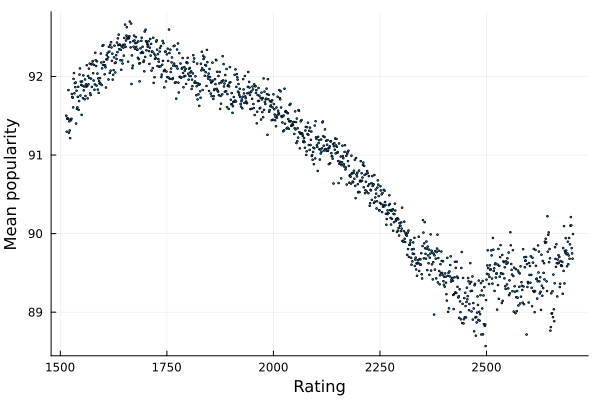

In [20]:
scatter(ratings, mean_popularities, 
        xlabel="Rating", ylabel="Mean popularity", 
        legend = false, ms = 1)

### Local regression (locally estimated scatterplot smoothing)

In [21]:
using Loess
model = loess(ratings, mean_popularities)

Loess.LoessModel{Float64}([1514.0; 1515.0; … ; 2702.0; 2703.0;;], [91.50089285714286, 91.29734361610969, 91.46286231884058, 91.46898895497026, 91.46113989637306, 91.82677824267782, 91.28403361344537, 91.42907488986783, 91.31239242685025, 91.21483375959079  …  89.9438202247191, 89.67980295566502, 89.86338797814207, 90.10055865921788, 90.21052631578948, 90.10526315789474, 89.81521739130434, 89.74757281553399, 89.68108108108108, 89.99425287356321], Dict([2555.0] => [89.40653192020463, -0.00020158297200882636], [2257.0] => [90.29286018112336, -0.004699206753941901], [1514.0] => [91.87066262375274, 0.002833806501756426], [2703.0] => [89.58578022581631, 0.0024881205909769513], [1662.0] => [92.136595540891, 0.0007122374292834431], [1960.0] => [91.69780518908625, -0.0031416924872954798], [2406.0] => [89.64093552817465, -0.0026153336982231365], [2108.0] => [91.14364402866835, -0.004429140762702033], [1811.0] => [92.08421618062839, -0.0013145958418149563]), Loess.KDTree{Float64}([1514.0; 1515.0;

In [23]:
popularity_predict = predict(model, ratings)

1190-element Vector{Float64}:
 91.87066262375274
 91.87348974350165
 91.87630348102756
 91.87910382328526
 91.88189075722394
 91.88466426979281
 91.88742434794104
 91.89017097861783
 91.8929041487724
 91.89562384535391
  ⋮
 89.5663719457283
 89.56874335215797
 89.57113044110864
 89.57353317539905
 89.57595151784781
 89.5783854312735
 89.58083487849478
 89.58329982233026
 89.58578022581631

In [24]:
methods(predict)

# 3 methods for generic function "predict" from StatsAPI:
 [1] predict(model::Loess.LoessModel, zs::AbstractMatrix)
     @ Loess ~/.julia/packages/Loess/C5Azc/src/Loess.jl:190
 [2] predict(model::Loess.LoessModel, zs::AbstractVector)
     @ Loess ~/.julia/packages/Loess/C5Azc/src/Loess.jl:182
 [3] predict(model::Loess.LoessModel{T}, z::Number) where T
     @ Loess ~/.julia/packages/Loess/C5Azc/src/Loess.jl:164

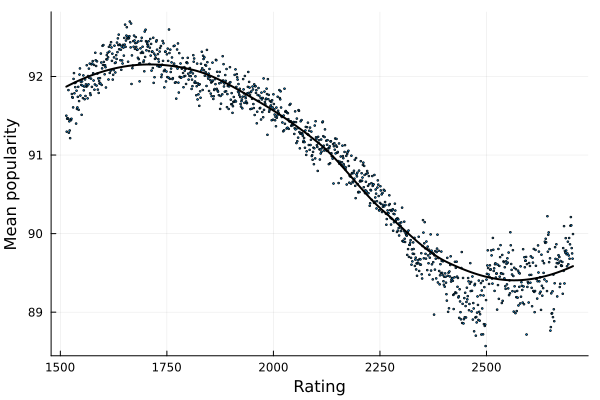

In [25]:
plot!(ratings, popularity_predict, lw=2, color = "black")

In [26]:
# The magic moment: a one-liner solution
combine(groupby(dat, :Rating), :Popularity => mean)

Row,Rating,Popularity_mean
,Int64,Float64
1,1514,91.5009
2,1515,91.2973
3,1516,91.4629
4,1517,91.469
5,1518,91.4611
6,1519,91.8268
7,1520,91.284
8,1521,91.4291
9,1522,91.3124
